In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [3]:
data_loc = '/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/datasets_2020_ff/'

In [4]:
file_str = 'Jan06_FlavFix_smear_1_std_xtd_zst.h5'

In [5]:
f5 = h5py.File(data_loc+file_str, 'r')

In [6]:
x_train = np.array( f5['x_train'] )
y_train = to_categorical ( np.array( f5['y_train'] ) )
w_train = np.array( f5['w_train'] )

In [7]:
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, LSTM, Masking, Input, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

In [8]:
from tensorflow.keras import regularizers

In [9]:
def lstmmodel(max_len, n_var, rec_units, ndense=[10], rec_layer='LSTM'):
    
    track_inputs = Input(shape=(max_len, n_var,))
    
#     mask = Masking( mask_value=0, name="masking_1")(track_inputs)
    
    if 'LSTM' in rec_layer:
        hidden = LSTM(units=rec_units,
#                   use_bias=False,
                  kernel_initializer = 'VarianceScaling', 
#                   kernel_regularizer = regularizers.l1_l2(l1= 0.001, l2 = 0.0001), 
#                   kernel_regularizer = regularizers.l2(l2 = 0.0001), 
#                   bias_regularizer = regularizers.l1_l2(l1= 1, l2 = 1), 
#                   activity_regularizer=regularizers.l1_l2(l1= 0.001, l2 = 0.0001),
                  name = 'lstm1')(track_inputs)
    if 'GRU' in rec_layer:
        hidden = GRU(units=rec_units,
#                   use_bias=False,
                  kernel_initializer = 'VarianceScaling', 
#                   kernel_regularizer = regularizers.l1_l2(l1= 0.001, l2 = 0.0001), 
                  kernel_regularizer = regularizers.l2(l2 = 0.0001), 
#                   bias_regularizer = regularizers.l1_l2(l1= 1, l2 = 1), 
#                   activity_regularizer=regularizers.l1_l2(l1= 0.001, l2 = 0.0001),
                  name = 'lstm1')(track_inputs)

    
    for ind,nd in enumerate(ndense):
        hidden = Dense(nd, activation='relu', kernel_initializer='lecun_uniform', name=f'dense_{ind}' )(hidden)
    
    output = Dense(3, activation='softmax', kernel_initializer='lecun_uniform', name = 'output_sigmoid')(hidden)
    
    model = Model(inputs=track_inputs, outputs=output)
    
    d_layers = ''.join([ str(dl) for dl in ndense ])
#     mname = f'rnn_{rec_layer}_{rec_units}_{d_layers}_nomask'
    mname = f'rnn_{rec_layer}_{rec_units}_{d_layers}_nomask_LSTMKIvs' #LSTM kernel initializer variance scaling
#     mname = f'rnn_{rec_layer}_{rec_units}_{d_layers}_nomask_LSTMKIgn' #LSTM kernel initializer glorot normal
#     mname = f'rnn_{rec_layer}_{rec_units}_{d_layers}_nomask_LSTMKIvs_KRl10.001l20.0001' #LSTM kernel regularizer
#     mname = f'rnn_{rec_layer}_{rec_units}_{d_layers}_nomask_LSTMKIvs_KRl20.0001' #LSTM kernel regularizer
#     mname = f'rnn_{rec_layer}_{rec_units}_{d_layers}_nomask_LSTMKIvs_BRl111l21' #LSTM bias regularizer
#     mname = f'rnn_{rec_layer}_{rec_units}_{d_layers}_nomask_LSTMKIvs_ARl11l21' #LSTM bias regularizer
    
    return model, mname

In [10]:
model, model_name = lstmmodel(15, 6, 50, [10], rec_layer='LSTM')

In [11]:
model.summary()
print(model_name)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 6)]           0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 50)                11400     
_________________________________________________________________
dense_0 (Dense)              (None, 10)                510       
_________________________________________________________________
output_sigmoid (Dense)       (None, 3)                 33        
Total params: 11,943
Trainable params: 11,943
Non-trainable params: 0
_________________________________________________________________
rnn_LSTM_50_10_nomask_LSTMKIvs


In [12]:
model_json = model.to_json()
with open(f'keras/model_{model_name}_arch.json', "w") as json_file:
    json_file.write(model_json)

In [13]:
adam = Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
model_output = f'keras/model_{model_name}_weights.h5'

In [16]:
train = True

In [17]:
if train:
    history = model.fit( x_train , y_train,
            batch_size=2**14,
            epochs=150,
            validation_split=0.1,
            shuffle = True,
            sample_weight= w_train,
            callbacks = [
                EarlyStopping(verbose=True, patience=150, monitor='val_accuracy'),
                ModelCheckpoint(model_output, monitor='val_accuracy', verbose=True, save_best_only=True)
                ],
            verbose=True
            )
    
model.load_weights(model_output)

Epoch 1/150
39/39 [==============================] - 18s 446ms/step - loss: 0.9021 - accuracy: 0.6068 - val_loss: 0.7895 - val_accuracy: 0.6788

Epoch 00001: val_accuracy improved from -inf to 0.67878, saving model to keras/model_rnn_LSTM_50_10_nomask_LSTMKIvs_weights.h5
Epoch 2/150
39/39 [==============================] - 12s 304ms/step - loss: 0.7674 - accuracy: 0.6882 - val_loss: 0.7541 - val_accuracy: 0.6966

Epoch 00002: val_accuracy improved from 0.67878 to 0.69663, saving model to keras/model_rnn_LSTM_50_10_nomask_LSTMKIvs_weights.h5
Epoch 3/150
39/39 [==============================] - 12s 301ms/step - loss: 0.7426 - accuracy: 0.7009 - val_loss: 0.7340 - val_accuracy: 0.7060

Epoch 00003: val_accuracy improved from 0.69663 to 0.70602, saving model to keras/model_rnn_LSTM_50_10_nomask_LSTMKIvs_weights.h5
Epoch 4/150
39/39 [==============================] - 12s 303ms/step - loss: 0.7296 - accuracy: 0.7070 - val_loss: 0.7233 - val_accuracy: 0.7105

Epoch 00004: val_accuracy improve

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 6)]           0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 50)                11400     
_________________________________________________________________
dense_0 (Dense)              (None, 10)                510       
_________________________________________________________________
output_sigmoid (Dense)       (None, 3)                 33        
Total params: 11,943
Trainable params: 11,943
Non-trainable params: 0
_________________________________________________________________


In [19]:
x_test = np.array( f5['x_test'] )
y_test = to_categorical ( np.array( f5['y_test'] ) )

In [20]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [21]:
import importlib

In [22]:
importlib.reload(plotting)

<module 'plotting' from '/gpfs/slac/atlas/fs1/u/rafaeltl/ML/L1BTag/Mar28/L1BTag/code/hls/notebooks/plotting.py'>

In [23]:
pred_test = model.predict(x_test, batch_size=2**10)

In [24]:
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1))))

Accuracy: 0.7431864294029602


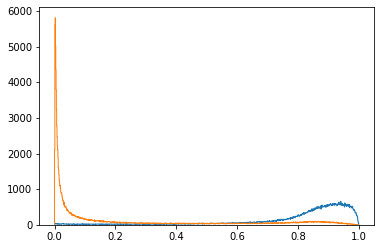

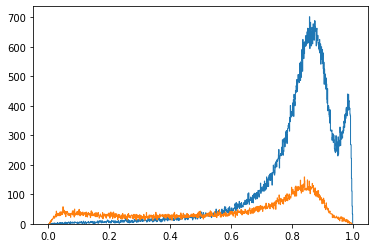

In [25]:
pb_b = pred_test[:,0] [y_test[:,0] == 1]
pc_b = pred_test[:,1] [y_test[:,0] == 1]
pl_b = pred_test[:,2] [y_test[:,0] == 1]
    
pc_c = pred_test[:,1] [y_test[:,1] == 1]
pb_c = pred_test[:,0] [y_test[:,1] == 1]
    
pl_l = pred_test[:,2] [y_test[:,2] == 1]
pb_l = pred_test[:,0] [y_test[:,2] == 1]

plt.Figure()

plt.hist( pb_b/(pb_b+pl_b), range=(0,1), bins=1000, histtype='step' )
plt.hist( pb_l/(pb_l+pl_l), range=(0,1), bins=1000, histtype='step' )

plt.show()


plt.Figure()

plt.hist( pb_b/(pb_b+pc_b), range=(0,1), bins=1000, histtype='step' )
plt.hist( pb_c/(pb_c+pc_c), range=(0,1), bins=1000, histtype='step' )

plt.show()

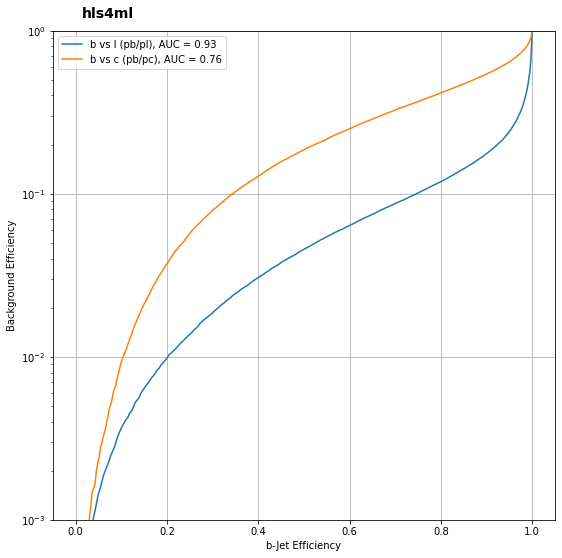

In [26]:
plt.figure(figsize=(9,9))
_ = plotting.makeRoc(y_test, pred_test)

In [ ]:
for layer in model.layers:
    print(layer.name)
#     plt.Figure()
    
    this_wgts = layer.get_weights()
#     if len(this_wgts) < 1: continue
    print(layer.get_config())
    
    for wgt in this_wgts:
        print(wgt)
        print()
#     max_wgts = np.max(this_wgts)
#     min_wgts = np.min(this_wgts)
#     plt.hist(this_wgts, bins=100, range=(min_wgts, max_wgts))
#     plt.xlabel(f'{layer.name}')
#     plt.show